In [1]:
# uv pip install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi pydantic streamlit uvicorn requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Load dataset
df_salary = pd.read_csv("./datasets/salary_dataset.csv")

In [12]:
# Inspect dataset
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_time      1000 non-null   int64  
 1   level_at_company  1000 non-null   int64  
 2   salary_in_usd     1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [14]:
# Copy DF to EDA DF
df_salary_eda = df_salary.copy()

In [15]:
# Copy DF to Bucketing DF
df_salary_bucketing = df_salary.copy()

### EDA

In [6]:
# Visualize data
df_salary_eda.head(10)

,company_time,level_at_company,salary_in_dollar
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [7]:
# Detect missing values
df_salary_eda.isna().sum()

company_time        0
level_at_company    0
salary_in_dollar    0
dtype: int64

In [8]:
# DF Statistics
df_salary_eda.describe()

,company_time,level_at_company,salary_in_dollar
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='company_time'>

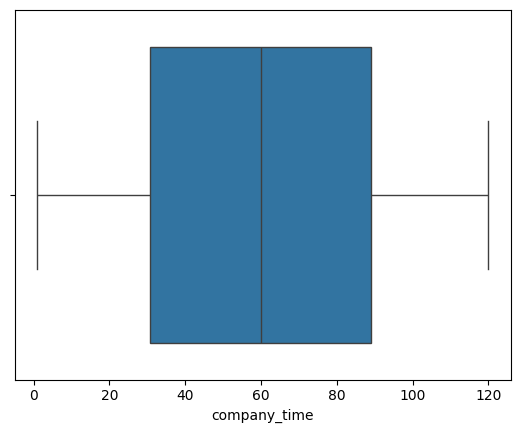

In [9]:
# Verify / detect outliers
sns.boxplot(data=df_salary_eda, x='company_time')

<Axes: xlabel='level_at_company'>

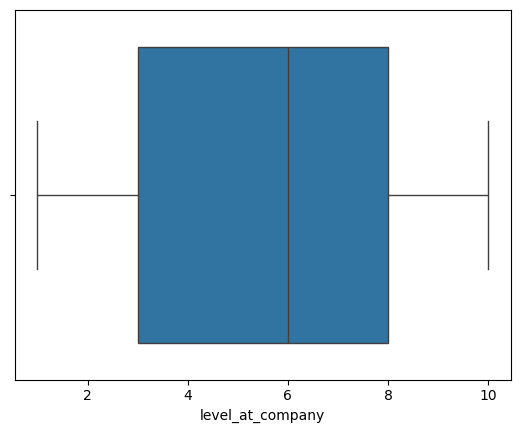

In [10]:
sns.boxplot(data=df_salary_eda, x='level_at_company')

<Axes: xlabel='salary_in_usd'>

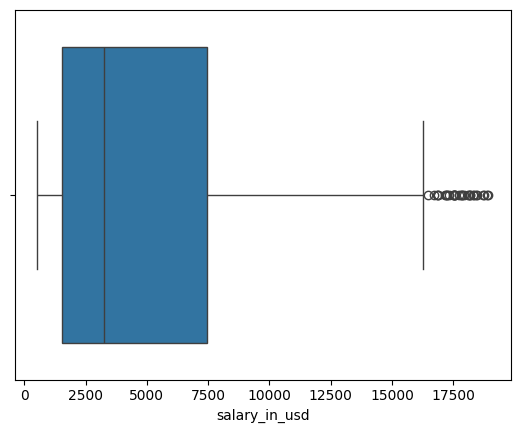

In [16]:
sns.boxplot(data=df_salary_eda, x='salary_in_usd')

<Axes: xlabel='company_time', ylabel='salary_in_usd'>

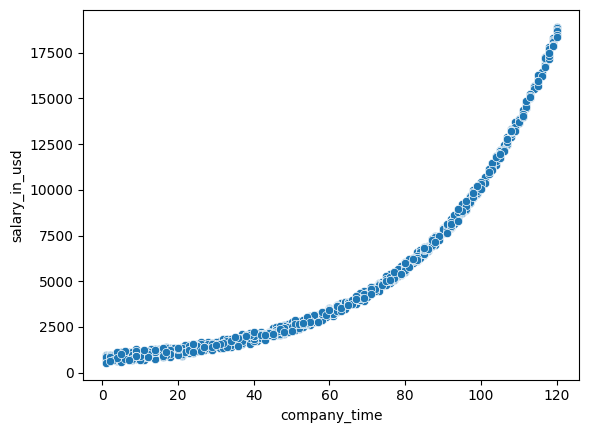

In [17]:
# Numeric variables with salary in USD
sns.scatterplot(data=df_salary_eda, x='company_time', y='salary_in_usd')

<Axes: xlabel='level_at_company', ylabel='salary_in_usd'>

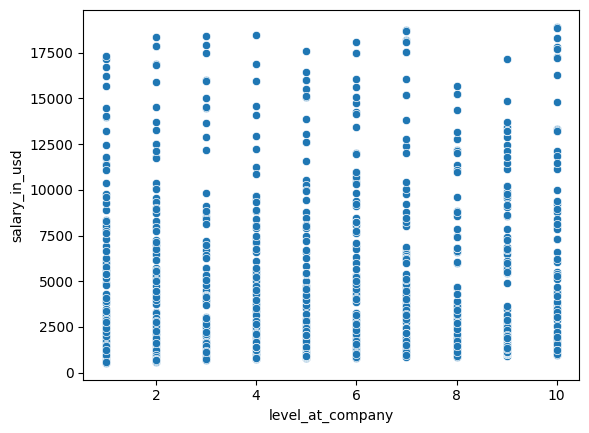

In [18]:
sns.scatterplot(data=df_salary_eda, x='level_at_company', y='salary_in_usd')

<Axes: xlabel='level_at_company', ylabel='company_time'>

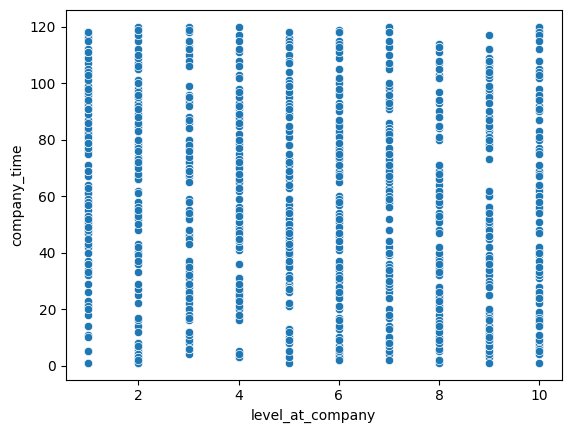

In [19]:
sns.scatterplot(data=df_salary_eda, x='level_at_company', y='company_time')

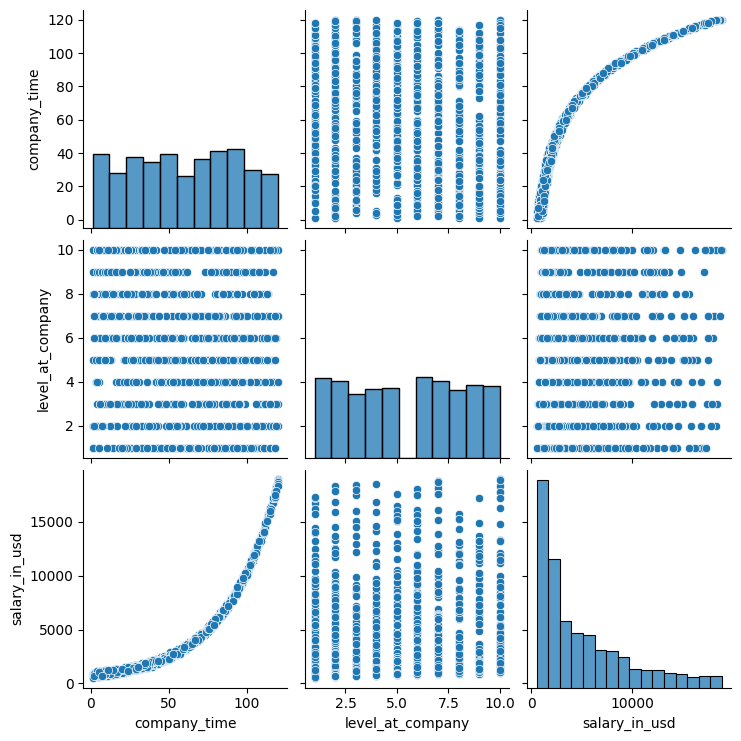

In [20]:
# Histogram
sns.pairplot(df_salary_eda)

<Axes: >

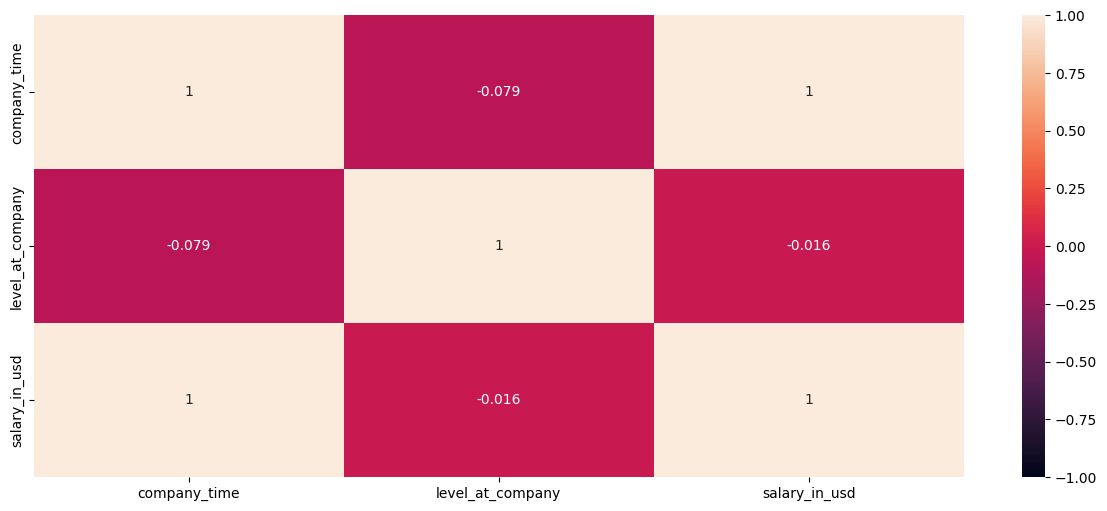

In [22]:
# Heatmap
plt.figure(figsize=(15,6))
sns.heatmap(df_salary_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

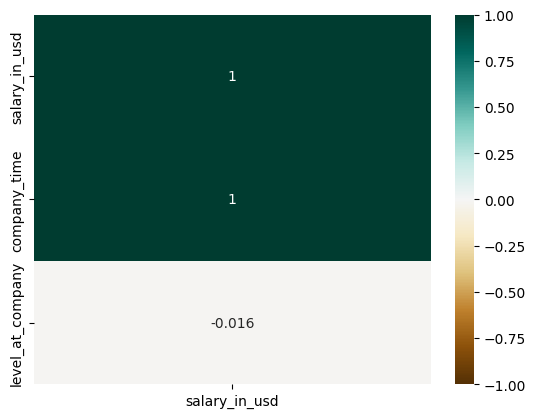

In [23]:
# Ranking format
sns.heatmap(df_salary_eda.corr('spearman')[['salary_in_usd']].sort_values(by="salary_in_usd", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")

In [24]:
# Bucketing Company Time
bins_company_time = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_company_time = ['0 - 9', '10 - 19', '20 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79', '80 - 89', '90 - 99', '100 - 109', '110 - 119', '120 - 129']
df_salary_bucketing['time_scale'] = pd.cut(x=df_salary_bucketing['company_time'], bins=bins_company_time, labels=labels_company_time, include_lowest=True)

In [25]:
df_salary_bucketing.head(10)

,company_time,level_at_company,salary_in_usd,time_scale
0,50,1,2288.13,40 - 49
1,49,4,2389.84,40 - 49
2,39,10,2158.73,30 - 39
3,51,1,2341.06,50 - 59
4,62,7,3584.20,60 - 69
5,105,10,12102.18,100 - 109
6,80,3,5723.35,70 - 79
7,85,2,6424.92,80 - 89
8,66,5,3916.18,60 - 69
9,73,5,4751.79,70 - 79


<Axes: xlabel='time_scale', ylabel='salary_in_usd'>

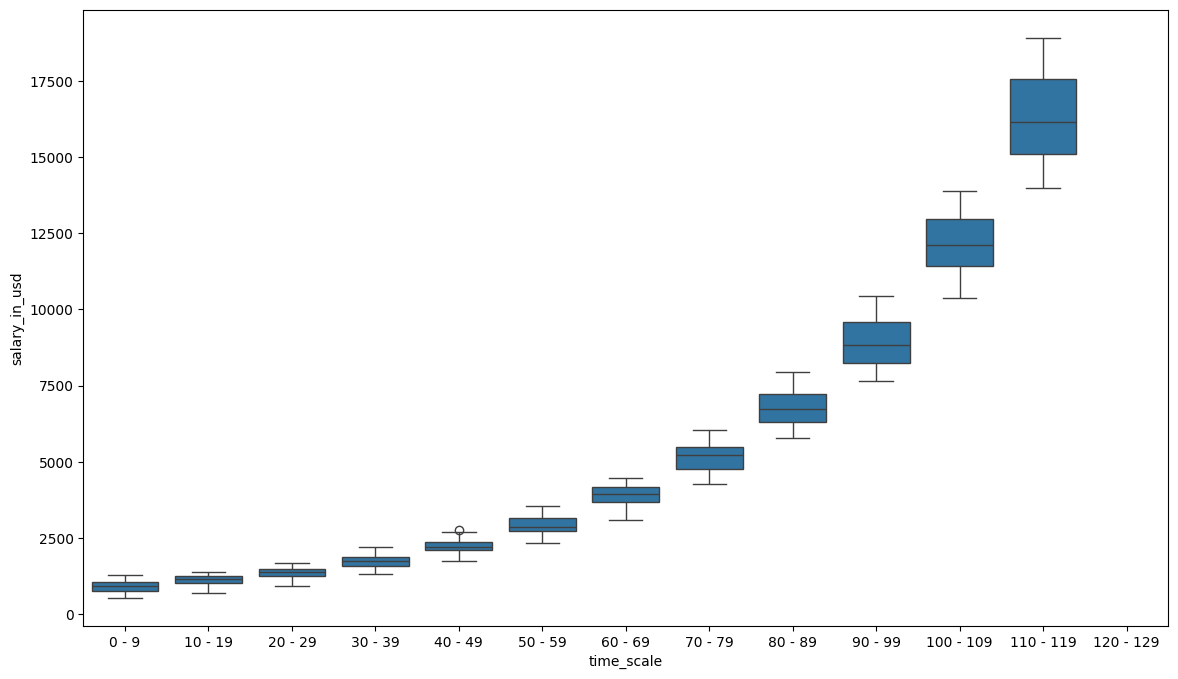

In [26]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salary_bucketing, x='time_scale', y='salary_in_usd')

### Train Linear Model

In [33]:
# Import libs
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

import numpy as np

In [28]:
# Create Training and Test DF
X = df_salary.drop(columns='salary_in_usd', axis=1)
y = df_salary['salary_in_usd']

In [29]:
# Split using KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [30]:
kf

KFold(n_splits=5, random_state=51, shuffle=True)

In [35]:
# Training Block for salary prediction

# Pipeline
# Standardization - company_time, level_at_company

# Column names
numeric_columns = ['company_time', 'level_at_company']

# Transformer for numeric columns
transformer_numerics = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numerics, numeric_columns)
    ])

# Creating main pipeline = Preprocessing + Training
model_regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

# Storage Training and Testing RMSE
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Storage Training R2 Score
r2score_fold_test = []

# Storage residuals
residuals = []

# Storage predictions
y_pred_total = []

for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  # Train model in the training set
  model_regr.fit(X_train, y_train)
  
  # Predict in the training set
  y_train_pred = model_regr.predict(X_train)
  y_test_pred = model_regr.predict(X_test)
  
  # Calculate RMSE for training and testing sets
  rmse_train = root_mean_squared_error(y_train, y_train_pred)
  rmse_test = root_mean_squared_error(y_test, y_test_pred)
  
  # Calculate R2 Score and residuals for testing set
  r2score_test = r2_score(y_test, y_test_pred)
  residuals_test = np.array(y_test - y_test_pred)
  
  # Storage metrics for each fold
  rmse_scores_fold_train.append(rmse_train)
  rmse_scores_fold_test.append(rmse_test)
  r2score_fold_test.append(r2score_test)
  residuals.append(residuals_test)
  y_pred_total.append(y_test_pred)
  
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
rmse_final_percentage = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuals = np.array(residuals).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Metrics Analysis - Linear Model

In [36]:
# Metrics
print(f'RMSE Train: {rmse_train_final}')
print(f'RMSE Test: {rmse_test_final}')
print(f'% Dif. RMSE Training and Test: {rmse_test_final}')
print(f'R2Score Train: {r2score_test_final}')

RMSE Train: 1882.8318426651392
RMSE Test: 1886.4504221336076
% Dif. RMSE Training and Test: 1886.4504221336076
R2Score Train: 0.8261178870584762


### Residuals Analysis - Linear Model

In [37]:
# Transform residuals in standard normal distribution
# (X - mean) / std
from scipy.stats import zscore
residuals_std = zscore(residuals)

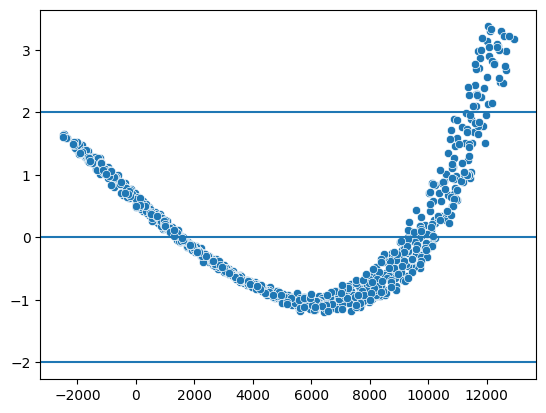

In [38]:
# Verify residuals linearity: Values between -2 and 2 (Standard scaled)
# Verify homoscedasticity: Values around the line with no tendency or form

sns.scatterplot(x=y_pred_total, y=residuals_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

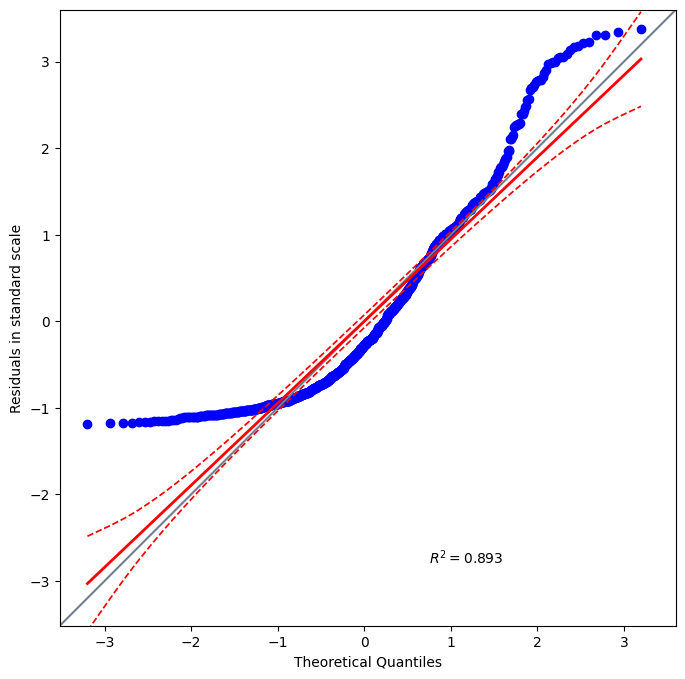

In [39]:
# Check if residuals follow a normal distribution
# QQ Plot
import pingouin as pg
plt.figure(figsize=(14, 8))
pg.qqplot(residuals, dist='norm', confidence=0.95)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Residuals in standard scale')
plt.show()

In [41]:
# Normality Test - Shapiro-Wilk
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuals)
print(f"Stat. Test {stat_shapiro} and P-Value {p_value_shapiro}")

Stat. Test 0.8919692179652287 and P-Value 7.013497918014801e-26


In [43]:
# Normality Test - Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuals, 'norm')
print(f"Stat. Test {stat_ks} and P-Value {p_value_ks}")

Stat. Test 0.5939999999999955 and P-Value 0.0


In [44]:
# Normality Test - Lilliefors
stat_ll, p_value_ll = lilliefors(residuals, 'norm', pvalmethod='table')
print(f"Stat. Test {stat_ll} and P-Value {p_value_ll}")

Stat. Test 0.11825983774680093 and P-Value 0.0009999999999998899
